# HW3 Yongjin Kim

For our homework of data cleaning, I proceed similiarly to our 3rd file used during the lecture.

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import math

%matplotlib inline

In [2]:
df = pd.read_csv('../../Lectures/Lecture 3/data/hw3.csv')

Note below that we have some NaN all over (and as noted, the whole **volumeUSD** column is NaN)

In [3]:
df.head(10)

,ts,open,high,low,close,volume,volumeUSD,token,chain
0,2021-12-02 14:00:00,22.4150,22.4913,22.0816,22.3516,3.150215e+04,NaN,UNI,ETH
1,2021-12-02 23:00:00,4.8043,4.8043,4.7426,4.7806,7.368623e+04,NaN,CRV,ETH
2,2021-12-10 15:00:00,182.4900,NaN,175.2100,175.8600,7.373675e+04,NaN,SOL,SOL
3,2021-12-10 18:00:00,3978.4300,3989.7400,3932.0000,3972.3400,1.850804e+04,NaN,ETH,ETH
4,2021-12-08 21:00:00,193.3240,194.2420,192.5640,193.1540,6.942691e+04,NaN,SOL,SOL
5,2021-12-08 12:00:00,3.8405,3.8789,3.7900,3.8392,3.788895e+05,NaN,CRV,ETH
6,2021-12-04 07:00:00,188.6880,196.4860,185.2630,190.8720,1.041406e+04,NaN,AAVE,ETH
7,2021-12-05 02:00:00,1.0015,1.0016,1.0012,1.0013,3.398077e+06,NaN,USDT,USDT
8,2021-12-09 10:00:00,1.0009,1.0010,1.0008,1.0009,7.236563e+06,NaN,USDT,USDT
9,2021-12-03 23:00:00,20.0490,20.1703,19.9061,19.9120,3.884822e+04,NaN,UNI,ETH


Now I try to get a crude overview of which parts need some cleaning. 

As seen below, we have a total of 2667 rows and clearly, **high, low, close, volumeUSD** have a significant number of null values.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2667 entries, 0 to 2666
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ts         2667 non-null   object 
 1   open       2667 non-null   float64
 2   high       2163 non-null   float64
 3   low        2378 non-null   float64
 4   close      2531 non-null   float64
 5   volume     2667 non-null   float64
 6   volumeUSD  0 non-null      float64
 7   token      2667 non-null   object 
 8   chain      2667 non-null   object 
dtypes: float64(6), object(3)
memory usage: 187.6+ KB


The **token** column also needs some cleaning to match the names. From the numbers, considering the majority, the shorter names would be the norm, so we should revise the latter half to match the former half.

In [5]:
df['token'].value_counts()

BTC                                   323
COMP                                  322
CRV                                   318
SOL                                   318
USDT                                  314
UNI                                   312
AAVE                                  312
ETH                                   298
<span name="tokenName">UNI</span>      30
<span name="tokenName">ETH</span>      28
<span name="tokenName">USDT</span>     19
<span name="tokenName">CRV</span>      17
<span name="tokenName">SOL</span>      16
<span name="tokenName">AAVE</span>     16
<span name="tokenName">BTC</span>      14
<span name="tokenName">COMP</span>     10
Name: token, dtype: int64

The **chain** column seems nice so would not need more work.

In [6]:
df['chain'].value_counts()

ETH     1663
BTC      337
SOL      334
USDT     333
Name: chain, dtype: int64

Other column names not mentioned (i.e. **open, volume**) may include some outlier or counter-intuitive datapoints (which may not be exclusive to the said two columns) so these columns also need a closer look. 

Lets take care of the obvious and delete duplicated data.

In [7]:
df.duplicated().sum()

307

In [8]:
df = df.drop_duplicates()

In [9]:
df.duplicated().sum()

0

In [10]:
len(df)

2360

Now lets start from the null values (i.e. **high, low, close**). We know the **open** column has no null values while other price related columns do. And as shown below, there are cases when all **high, low, close** columns' values are null (meaning we have only **open** price for that row as source of information)

In [11]:
df_H_L_C = df[['high','low','close']]

In [12]:
df_H_L_C.dropna(axis=0, thresh=2)

,high,low,close
0,22.4913,22.0816,22.3516
1,4.8043,4.7426,4.7806
2,NaN,175.2100,175.8600
3,3989.7400,3932.0000,3972.3400
4,194.2420,192.5640,193.1540
...,...,...,...
2661,284.8900,282.1800,282.3400
2662,244.4700,243.0960,243.7920
2663,NaN,231.1080,234.5980
2665,4249.7200,4183.2300,4198.8300


In [13]:
len(df) - len(df_H_L_C.dropna(axis=0, thresh=2))

83


I try not to discard any null values and make use of whatever exisiting price data (note that for any row we at least have the **open** price data) to fill in the others if there are any. Therefore, we have to be pretty sure that our **open** price data is as clean as possible since it is incorporated into imputing any row-wise null values.

So we first check whether the **open** price data is clean. Most likely problem would be the existence of any outliers. However for this, we have to group the data by the **token** value so in fact, we would first have to take care of this first.

In [14]:
df['token'].value_counts()

COMP                                  286
BTC                                   283
SOL                                   281
AAVE                                  280
CRV                                   279
USDT                                  278
UNI                                   270
ETH                                   270
<span name="tokenName">UNI</span>      25
<span name="tokenName">ETH</span>      25
<span name="tokenName">USDT</span>     17
<span name="tokenName">CRV</span>      16
<span name="tokenName">AAVE</span>     15
<span name="tokenName">SOL</span>      14
<span name="tokenName">BTC</span>      12
<span name="tokenName">COMP</span>      9
Name: token, dtype: int64

In [15]:
df.loc[df['token'].str.contains('</'), 'token'] = df.loc[df['token'].str.contains('</'), 'token'].str.extract('<span name="tokenName">(.*?)<\/span>')[0]

This seems to have gone right seeing from the matching number for each token.

In [16]:
df['token'].value_counts()

UNI     295
CRV     295
SOL     295
ETH     295
AAVE    295
USDT    295
COMP    295
BTC     295
Name: token, dtype: int64

Now try plotting the **open** column with regard to time for each **token**. It seems that here is no consipicuous outlier in the open prices. The USDT token does spike to 1.005 at some point but we should be wary of the scale of its y-axis since this is not that big a spike in absolute terms. Though we know USDT is pegged to valued to a dollar (meaning it should be equal to around 1), the 1.005 spike is pretty much acceptable.

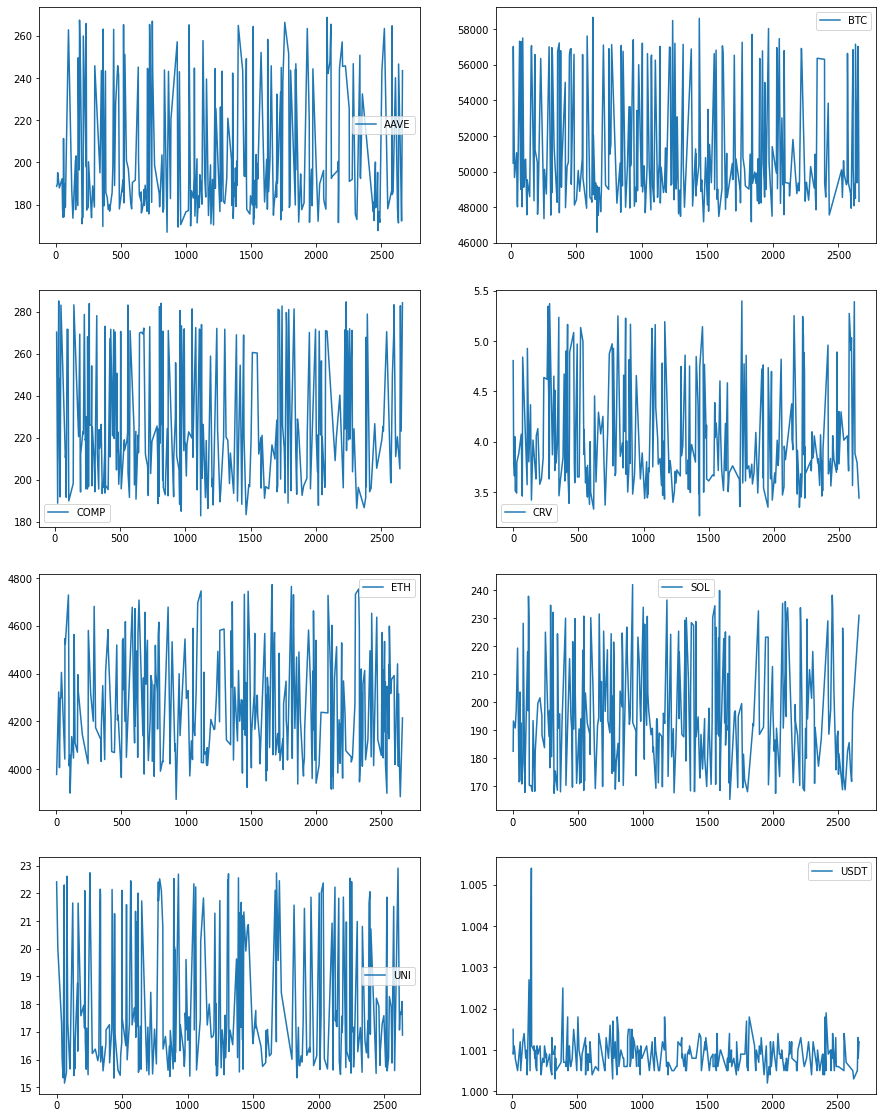

In [17]:
tokens_in_df = df.token.unique()

fig, axes = plt.subplots(nrows=math.ceil(tokens_in_df.size / 2), ncols=2, figsize=(15, 5 * math.ceil(tokens_in_df.size / 2)))

idx = 0
for label, df_token in df[['token', 'open']].groupby('token'):
    df_token['open'].plot(ax=axes[idx // 2, idx % 2], label=label)
    axes[idx // 2, idx % 2].legend()
    
    idx += 1


Now we look at **high, low, close** columns. First off, search for outlier values and assign them null values for now. There clearly are some outliers for the **close** column.

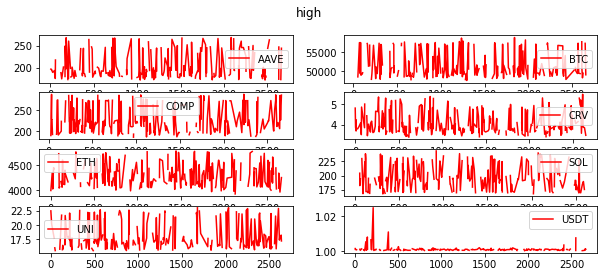

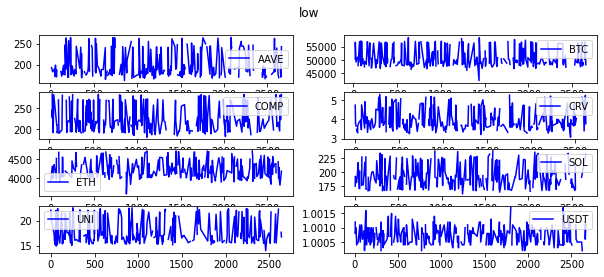

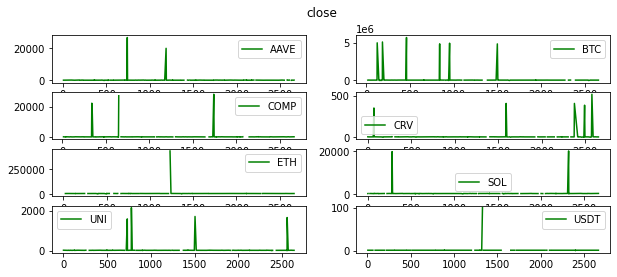

In [18]:
prices = ['high','low','close']
colors = ['red','blue','green']

for i in range(3):
    fig, axes = plt.subplots(nrows=math.ceil(tokens_in_df.size / 2), ncols=2, figsize=(10, 1 * math.ceil(tokens_in_df.size / 2)))
    fig.suptitle(prices[i])
    idx = 0
    for label, df_token in df[['token',prices[i]]].groupby('token'):
        df_token[prices[i]].plot(ax=axes[idx // 2, idx % 2], label=label, color = colors[i])
        axes[idx // 2, idx % 2].legend()
        idx += 1


I discern outliers as those rising 100\% or falling 50\% compared to the **open** price. From this it seems that again, the **close** price requires some revision.

In [20]:
prices = ['high','low','close']

In [21]:
df.loc[df.high / df.open >= 2]

,ts,open,high,low,close,volume,volumeUSD,token,chain


In [22]:
df.loc[df.low / df.open >= 2]

,ts,open,high,low,close,volume,volumeUSD,token,chain


In [29]:
df.loc[df.close / df.open >= 2, 'close'] = float('nan')
df.loc[df.close / df.open <= 0.5, 'close'] = float('nan')

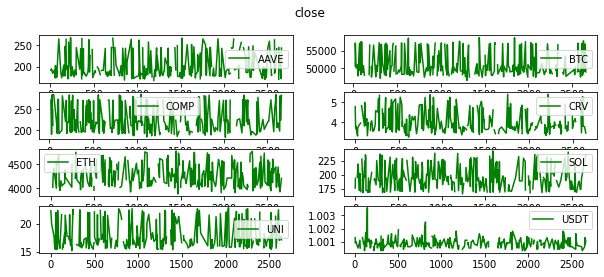

In [30]:
prices = ['close']
colors = ['green']

for i in [0]:
    fig, axes = plt.subplots(nrows=math.ceil(tokens_in_df.size / 2), ncols=2, figsize=(10, 1 * math.ceil(tokens_in_df.size / 2)))
    fig.suptitle(prices[i])
    idx = 0
    for label, df_token in df[['token',prices[i]]].groupby('token'):
        df_token[prices[i]].plot(ax=axes[idx // 2, idx % 2], label=label, color = colors[i])
        axes[idx // 2, idx % 2].legend()
        idx += 1

Now we start filling in null values. Starting for rows where all three are missing, match it with the open price value.

In [31]:
df_OHLC = df[['open','high','low','close']]
df.loc[df_OHLC.isnull().sum(axis=1) == 3, :]

,ts,open,high,low,close,volume,volumeUSD,token,chain
955,2021-12-05 11:00:00,49113.55,NaN,NaN,NaN,621.159777,NaN,BTC,BTC
1663,2021-12-08 21:00:00,216.56,NaN,NaN,NaN,2255.276000,NaN,COMP,ETH


In [32]:
condition = df_OHLC.isnull().sum(axis=1) == 3
df.loc[condition, :] = df.loc[condition, :].fillna(method='ffill', axis=1)

In [34]:
df.loc[condition,['volumeUSD']] = float("nan")
df.loc[condition,:]

,ts,open,high,low,close,volume,volumeUSD,token,chain
955,2021-12-05 11:00:00,49113.55,49113.55,49113.55,49113.55,621.159777,NaN,BTC,BTC
1663,2021-12-08 21:00:00,216.56,216.56,216.56,216.56,2255.276,NaN,COMP,ETH


Now there are max 2 missing values among **high, low, close** columns. I assign to each the following heuristic.

In [35]:
df.loc[df['high'].isnull(),['high']] = df_OHLC.loc[df['high'].isnull(), : ].max(axis=1, skipna=True)

In [37]:
df.loc[df_OHLC['high'].isnull(), 'high'].isnull().sum()

0

In [39]:
df.loc[df['low'].isnull(),['low']] = df_OHLC.loc[df['low'].isnull(), : ].min(axis=1, skipna=True)

In [40]:
df.loc[df_OHLC['low'].isnull(), 'low'].isnull().sum()

0

In [41]:
df.loc[df['close'].isnull(),'close'] = 0.5 * (df.loc[df['close'].isnull(),'high'] + df.loc[df['close'].isnull(),'low'])

In [42]:
df.loc[df_OHLC['close'].isnull(), 'close'].isnull().sum()

0

As shown below, all null values seem to be filled nicely.

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2360 entries, 0 to 2666
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ts         2360 non-null   object
 1   open       2360 non-null   object
 2   high       2360 non-null   object
 3   low        2360 non-null   object
 4   close      2360 non-null   object
 5   volume     2360 non-null   object
 6   volumeUSD  0 non-null      object
 7   token      2360 non-null   object
 8   chain      2360 non-null   object
dtypes: object(9)
memory usage: 184.4+ KB


Now we take a review of **high, low, close** prices. The data seems to be sufficiently cleaned and now ready for analysis

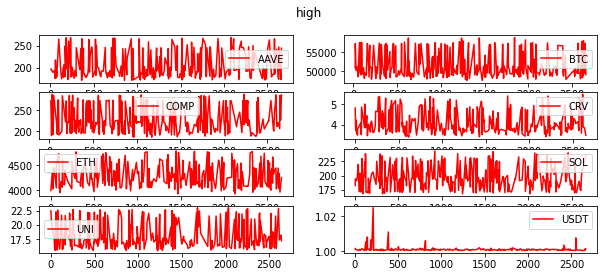

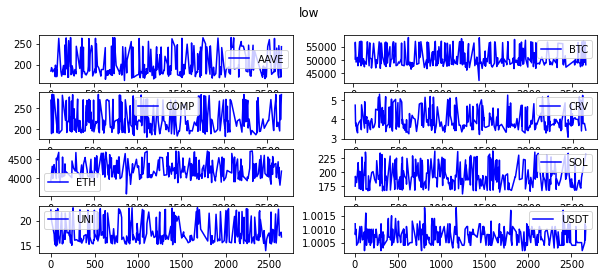

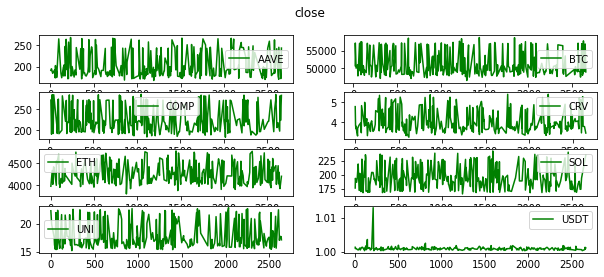

In [44]:
prices = ['high','low','close']
colors = ['red','blue','green']

for i in range(3):
    fig, axes = plt.subplots(nrows=math.ceil(tokens_in_df.size / 2), ncols=2, figsize=(10, 1 * math.ceil(tokens_in_df.size / 2)))
    fig.suptitle(prices[i])
    idx = 0
    for label, df_token in df[['token',prices[i]]].groupby('token'):
        df_token[prices[i]].plot(ax=axes[idx // 2, idx % 2], label=label, color = colors[i])
        axes[idx // 2, idx % 2].legend()
        idx += 1


Now I compute the originally sought answer: *calculating **volumeUSD** by chain*.

In [48]:
df['volumeUSD'] = df['volume'] * df['close']

In [49]:
df.groupby('chain')['volumeUSD'].sum()

chain
BTC     10958929323.360332
ETH     13647620723.018608
SOL      4075514373.264245
USDT     1008246768.229151
Name: volumeUSD, dtype: object